In [2]:
# Calculate the Reflux Coefficient from TEF
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os, sys
sys.path.append(os.path.abspath('../TEF'))
import TEF_Variables as tef

In [3]:
#def reflux(Qsg, hs, xi):
def reflux(case_id, xi):    
    #/Volumes/Extreme SSD/MITgcm outputs
    #../../Model_outputs
#     State = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(Qsg,'03d')) + '/state_' + str(format(hs,'03d')) + '.nc')
#     Grid = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(Qsg,'03d')) + '/grid_' + str(format(hs,'03d')) + '.nc')

    # Confine to the range of fjord
#     state = State.isel(X=range(120), Xp1=range(121), Y=range(30,39), T=range(1,len(State.T)))
#     grid = Grid.isel(X=range(120), Xp1=range(121), Y=range(30,39))
#    File1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/1_BaseCase/state_' + str(format(case_id,'03d')) + '.nc')
    File1 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase/state_' + str(format(case_id,'03d')) + '.nc')
    State = File1.isel(T=~File1.get_index("T").duplicated())
#    Grid = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/1_BaseCase/grid_' + str(format(case_id,'03d')) + '.nc')
    Grid = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase/grid_' + str(format(case_id,'03d')) + '.nc')

    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), T=range(1,len(State.T)))
    grid = Grid.isel(X=range(260), Xp1=range(261), Y=range(35,45))
    s = state.S.data.mean(2) # Salinity in T,Z,X
    u = (state.U.data[:,:,:,1:].mean(2) + state.U.data[:,:,:,:-1].mean(2)) / 2 # Along channel velocity
    ot = state.T.data # Time in seconds


    HFacC1 = grid.HFacC.data.mean(1)
    dyF1 = grid.dyF.data.mean(0)
    drF1 = grid.drF.data
    gridA = np.broadcast_to(drF1[:, np.newaxis], HFacC1.shape) * np.broadcast_to(dyF1[np.newaxis, :], HFacC1.shape) * HFacC1 # Grid Area
    da = np.broadcast_to(gridA[np.newaxis,:,:], u.shape)

    S = state.S.data
    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC
    
    
    Qin = np.empty(len(xi))
    Qout = np.empty(len(xi))
    Sin = np.empty(len(xi))
    Sout = np.empty(len(xi))
    
    t0 = 89 # 274
    # Exclude the upper (surface) layer for TEF calculation
    for t in range(U.shape[0]):
        
        Uzx = u[t,:,:] # Steady-state along-channel velocity
        for j in range(Uzx.shape[1]):
            if any(Uzx[:,j]>0)==False:
                pass
            else:
                mid = np.where(Uzx[:,j]>0)[0][0]
                if mid>0:
                    S[t,:mid,:,j] = 0
                    U[t,:mid,:,j] = 0
                else:
                    pass

#     Uzx = u[t0:,:,:].mean(0) # Steady-state along-channel velocity
#     for j in range(Uzx.shape[1]):
#         if any(Uzx[:,j]>0)==False:
#             pass
#         else:
#             mid = np.where(Uzx[:,j]>0)[0][0]
#             if mid>0:
#                 S[:,:mid,:,j] = 0
#                 U[:,:mid,:,j] = 0
#             else:
#                 pass
    
    
    for i in range(len(xi)):
        
        
        
        tef_q1, tef_vel1, tef_da1, tef_qs1, tef_qs21, sbins1 = tef.process_section(U,S,DA,ot,xi[i],23,testing=False)

        qin1, qout1, sin1, sout1 = tef.bulk_calc(tef_q1, tef_vel1, tef_da1, tef_qs1, tef_qs21, sbins1, ot)
    
#         Qin[i] = qin1[t0:].mean() # Time averaging from 1+t0 hour
#         Qout[i] = qout1[t0:].mean()
#         Sin[i] = sin1[t0:].mean() # Time averaging from 1+t0 hour
#         Sout[i] = sout1[t0:].mean()
        Qin[i] = qin1[t0:].mean() # Time averaging from 1+t0 hour
        Qout[i] = qout1[t0:].mean()
        Sin[i] = sin1[t0:].mean() # Time averaging from 1+t0 hour
        Sout[i] = sout1[t0:].mean()
        
    a002 = (Sin[0]/Sout[0])*(Sout[1]-Sout[0])/(Sout[1]-Sin[0])
    a001 = (Qin[0]-Qin[1]) / Qin[0]    
    a11 = (Sout[1]/Sin[1])*(Sin[1]-Sin[0])/(Sout[1]-Sin[0])    
    a01 = (Sout[1]/Sout[0])*(Sout[0]-Sin[0])/(Sout[1]-Sin[0])
    
    a10 = (Sin[0]/Sin[1])*(Sout[1]-Sin[1])/(Sout[1]-Sin[0])
    
    #a00 = -(Qout[0]/Qin[0])*(Sout[1]-Sout[0])/(Sout[1]-Sin[0])
    #a11 = -(Qin[1]/Qout[1])*(Sin[1]-Sin[0])/(Sout[1]-Sin[0])
    #a01 = (Qin[1]/Qin[0])*(Sout[1]-Sin[1])/(Sout[1]-Sin[0])
    #a10 = (Qout[0]/Qout[1])*(Sout[0]-Sin[0])/(Sout[1]-Sin[0])
    
    q0 = Qin[0]
    q1 = -Qout[-1]
    Q0 = -Qout[0]
    Q1 = Qin[-1]
    f0 = Sin[0]*q0
    f1 = Sout[-1]*q1
    F0 = Sout[0]*Q0
    F1 = Sin[-1]*Q1
    
    A = np.array([[q1, q0, 0, 0], [f1, f0, 0, 0], [0, 0, q1, q0], [0, 0, f1, f0]])
    B = np.array([Q1, F1, Q0, F0])
    X = np.linalg.solve(A,B) # a11, a01, a10, a00
    
    #return a00,q q0, q1, Q0
    #return a001, a002, X[-1]
    return X[0],X[-1],q1,q0,Q1,Q0

In [4]:
#qsg = 250
hs = np.array([1,2,3,4,5])
# xrange = np.array([47,97])
xrange = np.array([120,235])

eflx = np.empty(len(hs))
rflx = np.empty(len(hs))
q1 = np.empty(len(hs))
q0 = np.empty(len(hs))
Q1 = np.empty(len(hs))
Q0 = np.empty(len(hs))

for j in range(len(hs)):
    
    eflx[j], rflx[j], q1[j], q0[j], Q1[j], Q0[j] = reflux(hs[j],xrange)

  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120


In [5]:
q1, q0, Q1, Q0

(array([2423.74567441, 3747.48034528, 4838.94512668, 5719.5561161 ,
        6282.10174435]),
 array([9024.63108578, 9069.27998963, 8925.37274129, 8745.58928875,
        8160.85462874]),
 array([2672.29225714, 3997.46199167, 5087.16043472, 5969.74319531,
        6530.56922   ]),
 array([8776.80278027, 8819.76960836, 8676.91261766, 8495.50289802,
        7912.03856441]))

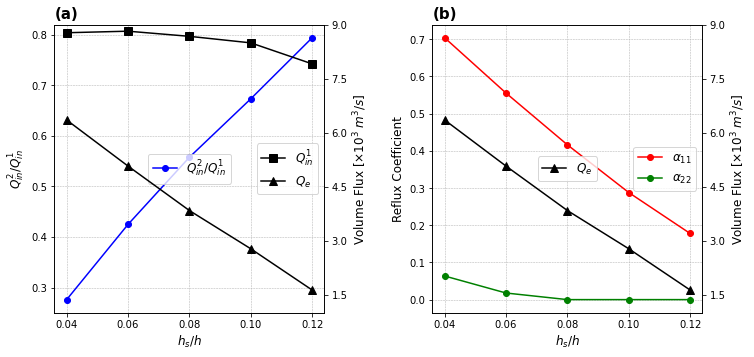

In [47]:
hsr = np.array([0.04,0.06,0.08,0.10,0.12]) # hs/h

fig1 = plt.figure(figsize=(10,5))
fig1.tight_layout()

# Plot Qin and Qin ratio
ax1 = fig1.add_subplot(121)
plt.grid(linestyle = '--', linewidth = 0.5)
ax1.plot(hsr,q1/Q0,'o-b',label=r'$Q^2_{in}/Q^1_{in}$')
ax1.legend(loc='center', fontsize=12)
ax1.set_xticks([0.04, 0.06, 0.08, 0.10, 0.12])
ax1.set_xlabel(r"$h_s/h$",fontsize=12)
#ax1.set_ylim([0, .7])
ax1.set_ylabel(r"$Q^2_{in}/Q^1_{in}$",fontsize=12)
ax1.set_title('(a)', loc='left', size=15, weight='bold')


ax2=ax1.twinx()
ax2.plot(hsr,Q0/1e3,'s-k',ms=8,label=r'$Q^1_{in}$')
ax2.plot(hsr,(Q0-q1)/1e3,'^-k',ms=8,label=r'$Q_e$')
ax2.legend(loc='right', fontsize=12)
ax2.set_ylim([1, 9])
ax2.set_yticks([1.5, 3, 4.5, 6, 7.5, 9])
ax2.set_ylabel(r"Volume Flux $[\times10^3\;m^3/s]$",fontsize=12)


# Plot reflux coefs and Qe
ax3 = fig1.add_subplot(122)
plt.grid(linestyle = '--', linewidth = 0.5)
ax3.plot(hsr,rflx,'o-r',label=r'$\alpha_{11}$')
eflx[eflx<0] = 0
ax3.plot(hsr,eflx,'o-g',label=r'$\alpha_{22}$')
ax3.legend(loc='right', fontsize=12)
ax3.set_xticks([0.04, 0.06, 0.08, 0.10, 0.12])
ax3.set_xlabel(r"$h_s/h$",fontsize=12)
#ax1.set_ylim([0, .7])
ax3.set_ylabel(r"Reflux Coefficient",fontsize=12)
ax3.set_title('(b)', loc='left', size=15, weight='bold')

ax4=ax3.twinx()
ax4.plot(hsr,(Q0-q1)/1e3,'^-k',ms=8,label=r'$Q_e$')
ax4.legend(loc='center', fontsize=12)
# ax2.set_ylim([0, 2800])
ax4.set_ylim([1, 9])
ax4.set_yticks([1.5, 3, 4.5, 6, 7.5, 9])
ax4.set_ylabel(r"Volume Flux $[\times10^3\;m^3/s]$",fontsize=12)

# set the spacing between subplots
plt.subplots_adjust(left=0.05,
                    bottom=0.1, 
                    right=0.95, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [48]:
fig_path ="/home/1959/Jupyter_Figs/FjordModeling/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig1.savefig(fig_path + '/2-TEF_Reflux.png', dpi=200, bbox_inches='tight') 